# Data Loading and Exploration

In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import pylab as pl

# Data Loading

In [2]:
print('Loading park zone data')
df1 = gpd.read_file('raw_data/Parks Zones.geojson')
print('Loading sidewalk data')
df2 = gpd.read_file('raw_data/Sidewalk Centerline.geojson')
print('Loading street data')
df3 = gpd.read_file('raw_data/NYC Street Centerline (CSCL).geojson')
# use API, database too big
#print('Loading tree data')
#df4 = gpd.read_file('raw_data/2015 Street Tree Census - Tree Data.geojson')
print('Done')

Loading park zone data
Loading sidewalk data
Loading street data
Done


## Select data by Borough

In [3]:
borough = 'M'
boroughs = {'M': '1',  # Manhattan
            '?': '2',  # Bronx
            '?': '3',  # Brooklyn
            '?': '4',  # Queens
            '?': '5'}  # Staten Island
# missing boroughs are: {'B', 'Q', 'R', 'X'}

In [4]:
# selecting Manhattan
borough_df1 = df1.loc[df1['borough'] == borough]

In [5]:
borough_df2 = df2

In [6]:
# boroughs are {}'1', '2', '3', '4', '5', '6'}
# selecting Manhattan
borough_df3 = df3.loc[df3['borocode'] == boroughs[borough]]

## Plotting Borough Data

Text(0.5,1,'NYC Map of Running Areas')

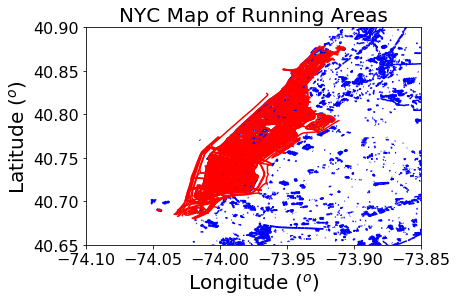

In [7]:
fig, ax1 = pl.subplots()#figsize=(12, 12))
borough_df1.plot(ax=ax1, color='y', label='x')  # roads
borough_df2.plot(ax=ax1, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax1, color='r', label='z')  # parks

# to do: remove data outside of proper borough
x_range = [-74.05, -73.9]
y_range = [40.65, 40.9]
x0 = pl.mean(x_range)
y0 = pl.mean(y_range)
dx = x_range[1] - x_range[0]
dy = y_range[1] - y_range[0]
dd = max([dx, dy]) / 2.
pl.xlim([x0-dd, x0+dd])
pl.ylim([y0-dd, y0+dd])
pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})


## Zoom on Central Park

In [9]:
lon0_deg = -73.97
lat0_deg = 40.77
r_deg = 0.01
borough_df1 = select_data(borough_df1, lon0_deg, lat0_deg, r_deg)
borough_df2 = select_data(borough_df2, lon0_deg, lat0_deg, r_deg)
borough_df3 = select_data(borough_df3, lon0_deg, lat0_deg, r_deg)

/home/aubin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/aubin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/aubin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

## Select Subset of the Data for Proof of Concept

The goal is to limit the amount of data so it is easier to visualize and work with for debugging

In [319]:
def select_data(df, lon0_deg, lat0_deg, r_deg):
    """
    drops the data outside a radius r_deg around (lon0_deg, lat0_deg)
    """
    df['rep_x_rad'] = pd.Series([df['geometry'].iloc[i].representative_point().x*pl.pi/180. for i in range(len(df.index))], index=df.index)
    df['rep_y_rad'] = pd.Series([df['geometry'].iloc[i].representative_point().y*pl.pi/180. for i in range(len(df.index))], index=df.index)

    lon0 = pl.float64(lon0_deg)*pl.pi/180.  # lambda
    lat0 = pl.float64(lat0_deg)*pl.pi/180.  # phi

    # rounding could be an issue...
    df['diff_to_ref_rad'] = pl.arccos(pl.sin(lat0)*pl.sin(df['rep_y_rad'])+pl.cos(lat0)*pl.cos(df['rep_y_rad'])*pl.cos(df['rep_x_rad']-lon0))
    invalid = df['diff_to_ref_rad'] * 180./pl.pi > r_deg
    df.drop(df.index[invalid], inplace=True)
        
    return df

## Plot Sub-Data

Text(0.5,1,'NYC Map of Running Areas')

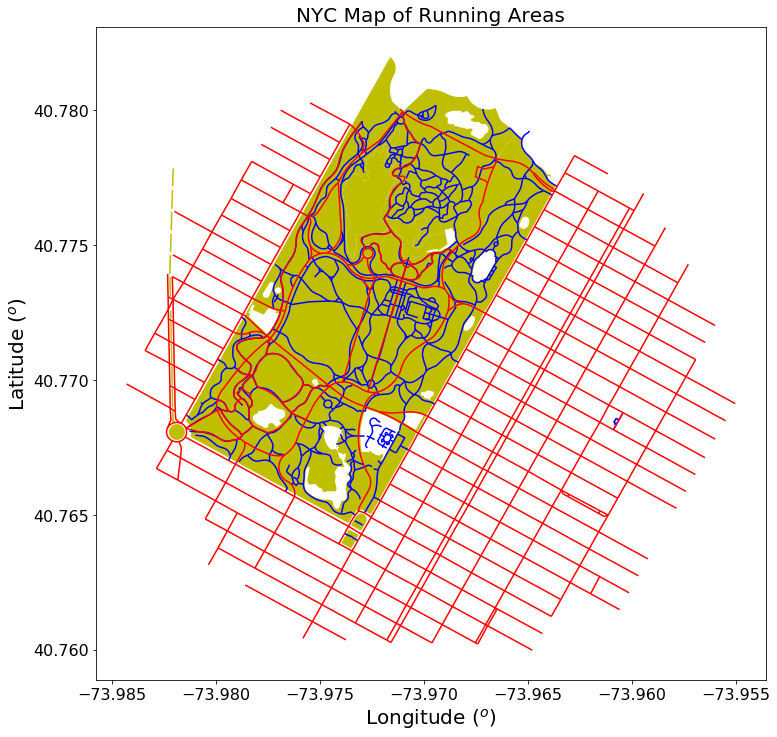

In [17]:
# plotting the selected data
fig, ax2 = pl.subplots(figsize=(12, 12))
borough_df1.plot(ax=ax2, color='y', label='x')  # roads
borough_df2.plot(ax=ax2, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax2, color='r', label='z')  # parks

# zoom on a specific region
#x_range = [-73.99, -73.95]
#y_range = [40.75, 40.8]
#x0 = pl.mean(x_range)
#y0 = pl.mean(y_range)
#dx = x_range[1] - x_range[0]
#dy = y_range[1] - y_range[0]
#dd = max([dx, dy]) / 2.
#pl.xlim([x0-dd, x0+dd])
#pl.ylim([y0-dd, y0+dd])
pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})

## Reformats Data

Converting the segment data into vertices and distance between them.

TO DO: Make sure all the segments are present. The "T-shape" ones may be missing.

In [275]:
def lon_lat_to_name(lon, lat):
    """
    converts lon (float) and lat (float) to 'lon_lat'
    """
    return "{0:f}_{1:f}".format(lon, lat)

In [276]:
# extract the important information from the segments
data_for_df = {'lon_start': [], 'lat_start': [], 'lon_end': [], 'lat_end': [], 'distance':[], 'type': [],
               'connections_start': [], 'connections_end': [], 'name_start': [], 'name_end': []}
for i in range(len(borough_df3.index)):
    data_for_df['lon_start'].append(borough_df3['geometry'].iloc[i].boundary[0].x)
    data_for_df['lat_start'].append(borough_df3['geometry'].iloc[i].boundary[0].y)
    data_for_df['lon_end'].append(borough_df3['geometry'].iloc[i].boundary[1].x)
    data_for_df['lat_end'].append(borough_df3['geometry'].iloc[i].boundary[1].y)
    data_for_df['distance'].append(borough_df3['geometry'].iloc[i].length)
    data_for_df['type'].append('street')
    data_for_df['connections_start'].append([])
    data_for_df['connections_end'].append([])
    data_for_df['name_start'].append(lon_lat_to_name(data_for_df['lon_start'][-1], data_for_df['lat_start'][-1]))
    data_for_df['name_end'].append(lon_lat_to_name(data_for_df['lon_end'][-1], data_for_df['lat_end'][-1]))
for i in range(len(borough_df2.index)):
    data_for_df['lon_start'].append(borough_df2['geometry'].iloc[i].boundary[0].x)
    data_for_df['lat_start'].append(borough_df2['geometry'].iloc[i].boundary[0].y)
    data_for_df['lon_end'].append(borough_df2['geometry'].iloc[i].boundary[1].x)
    data_for_df['lat_end'].append(borough_df2['geometry'].iloc[i].boundary[1].y)
    data_for_df['distance'].append(borough_df2['geometry'].iloc[i].length)
    data_for_df['type'].append('sidewalk')
    data_for_df['connections_start'].append([])
    data_for_df['connections_end'].append([])
    data_for_df['name_start'].append(lon_lat_to_name(data_for_df['lon_start'][-1], data_for_df['lat_start'][-1]))
    data_for_df['name_end'].append(lon_lat_to_name(data_for_df['lon_end'][-1], data_for_df['lat_end'][-1]))

## Make Connections between vertices

In [277]:
index_list = [5, 87, 149]  # a few segments to help debuging
for i in range(len(data_for_df['lon_start'])):
    for j in range(i+1, len(data_for_df['lon_start'])):
#for k in range(len(index_list)):
#    for kk in range(k+1, len(index_list)):
#        i = index_list[k]
#        j = index_list[kk]
        if data_for_df["lon_start"][i] == data_for_df["lon_start"][j] and data_for_df["lat_start"][i] == data_for_df["lat_start"][j]:
            #print('start-start')
            data_for_df['connections_start'][i].append(j)
            data_for_df['connections_start'][j].append(i)
        if data_for_df["lon_start"][i] == data_for_df["lon_end"][j] and data_for_df["lat_start"][i] == data_for_df["lat_end"][j]:
            #print('start-end')
            data_for_df['connections_start'][i].append(j)
            data_for_df['connections_end'][j].append(i)
        if data_for_df["lon_end"][i] == data_for_df["lon_start"][j] and data_for_df["lat_end"][i] == data_for_df["lat_start"][j]:
            #print('end-start')
            data_for_df['connections_end'][i].append(j)
            data_for_df['connections_start'][j].append(i)
        if data_for_df["lon_end"][i] == data_for_df["lon_end"][j] and data_for_df["lat_end"][i] == data_for_df["lat_end"][j]:
            #print('end-end')
            data_for_df['connections_end'][i].append(j)
            data_for_df['connections_end'][j].append(i)
#pl.array(data_for_df["connections_start"])[index_list]

In [278]:
def convert_segments_to_vertex(data):
    """
    Given the list of segments and their connections, provides vertex-to-vertex information
    """
    vertices = {'vertex_start': [], 'vertex_end': [], 'distance': [], 'type': []}
    
    # loop over all the segments
    for i in range(len(data['type'])):
        # loop over the 2 extremities of each segment
        for which in ['start', 'end']:
            name1 = lon_lat_to_name(data['lon_'+which][i], data['lat_'+which][i])

            # loop over the connected segments
            for j in data['connections_'+which][i]:

                # find the vertices who are the same to identify which distance to keep
                if data['name_start'][j] == name1:
                    name2 = data['name_end'][j]
                elif data['name_end'][j] == name1:
                    name2 = data['name_start'][j]
                else:
                    raise ValueError('Problem!!!')
                
                # stores the path informations
                vertices['vertex_start'].append(name1)
                vertices['vertex_end'].append(name2)
                vertices['distance'].append(data['distance'][j])
                vertices['type'].append(data['type'][j])

                return vertices
    

In [279]:
vertex_data = convert_segments_to_vertex(data_for_df)
print()

## Write DataFrame to File

In [280]:
new_df = pd.DataFrame(data_for_df, columns=['lon_start', 'lat_start', 'lon_end', 'lat_end', 'distance', 'type', 'connections_start', 'connections_end'])
new_df.to_csv("selected_data_segments.csv")
print(len(new_df.index))
new_df.iloc[index_list]
#new_df.head()

1295


,lon_start,lat_start,lon_end,lat_end,distance,type,connections_start,connections_end
5,-73.976458,40.775533,-73.975955,40.776220,0.000851,street,"[87, 149]","[68, 88, 185]"
87,-73.976912,40.774909,-73.976458,40.775533,0.000771,street,"[468, 569]","[5, 149]"
149,-73.979287,40.776725,-73.976458,40.775533,0.003070,street,"[493, 536]","[5, 87]"


In [281]:
new_df2 = pd.DataFrame(vertex_data, columns=['vertex_start', 'vertex_end', 'distance', 'type'])
new_df2.to_csv("selected_data_vertices.csv")
print(len(new_df2.index))
new_df2.head()

5644


,vertex_start,vertex_end,distance,type
0,-73.961110_40.769064,-73.962704_40.769739,0.001731,street
1,-73.961110_40.769064,-73.960429_40.768784,0.000737,street
2,-73.961110_40.769064,-73.961548_40.768432,0.000770,street
3,-73.960602_40.769749,-73.960110_40.770432,0.000842,street
4,-73.960602_40.769749,-73.958365_40.768798,0.002430,street


## Debugging Plot to Show Intersections

-73.97073018211728 40.77637907108142


Text(0.5,1,'NYC Map of Running Areas')

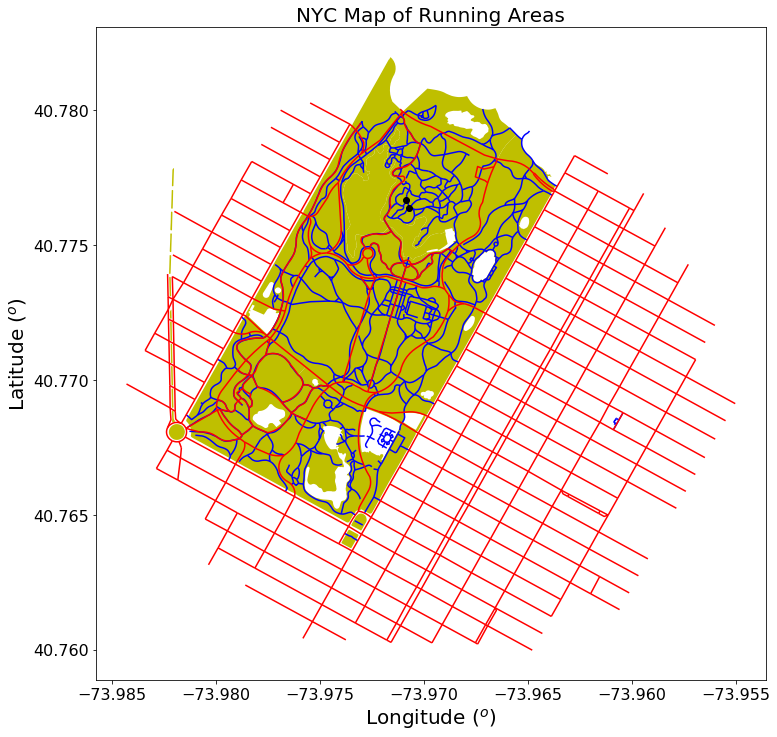

In [132]:
# plotting the selected data
fig, ax2 = pl.subplots(figsize=(12, 12))
borough_df1.plot(ax=ax2, color='y', label='x')  # roads
borough_df2.plot(ax=ax2, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax2, color='r', label='z')  # parks

n = -1
pl.plot(data_for_df['lon_start'][n], data_for_df['lat_start'][n], 'ok')
pl.plot(data_for_df['lon_end'][n], data_for_df['lat_end'][n], 'ok')
print(data_for_df['lon_start'][n], data_for_df['lat_start'][n])

pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})

# Distance Minimizer Algorithm

Implementing Dijkstra's algorithm to minimize distance, but keeping the weights (distances) explicit

In [320]:
"""
Initial code taken from https://gist.github.com/kachayev/5990802
"""
from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    g = defaultdict(list)
    for l,r,c in edges:
        g[l].append((c,r))
    #print(g)

    q, seen, mins = [(0,f,())], set(), {f: 0}
    #print(q, seen, mins)
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            #print('-', path)
            
            # if arrived to last vertex, done
            if v1 == t:
                #print('----------')
                return (cost, path)

            for c, v2 in g.get(v1, ()):
                #print('===', c, v2)
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = cost + c
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return float("inf")

if __name__ == "__main__":
    edges = [
        ("A", "B", 7),
        ("A", "D", 5),
        ("B", "C", 8),
        ("B", "D", 9),
        ("B", "E", 7),
        ("C", "E", 5),
        ("D", "E", 15),
        ("D", "F", 6),
        ("E", "F", 8),
        ("E", "G", 9),
        ("F", "G", 11)
    ]

    print("=== Dijkstra ===")
    #print(edges)
    print("A -> E:")
    print(dijkstra(edges, "A", "E"))
    #print("F -> G:")
    #print(dijkstra(edges, "F", "G"))

=== Dijkstra ===
A -> E:
(14, ('E', ('B', ('A', ()))))


In [321]:
new_df2.head()

,vertex_start,vertex_end,distance,type
0,-73.961110_40.769064,-73.962704_40.769739,0.001731,street
1,-73.961110_40.769064,-73.960429_40.768784,0.000737,street
2,-73.961110_40.769064,-73.961548_40.768432,0.000770,street
3,-73.960602_40.769749,-73.960110_40.770432,0.000842,street
4,-73.960602_40.769749,-73.958365_40.768798,0.002430,street


In [322]:
edges = []
for i in range(len(new_df2.index)):
    edges.append((new_df2['vertex_start'].iloc[i], new_df2['vertex_end'].iloc[i], new_df2['distance'].iloc[i]))
edges[:5]

start_point = edges[10][0]
end_point = edges[1300][0]

xxx = dijkstra(edges, start_point, end_point)
print(xxx)


(0.009228139580452505, ('-73.958365_40.768798', ('-73.960602_40.769749', ('-73.960110_40.770432', ('-73.961708_40.771106', ('-73.963214_40.771740', ('-73.962751_40.772371', ('-73.962291_40.773007', ('-73.962506_40.773098', ('-73.962044_40.773734', ()))))))))))


- -73.958365_40.768798
- -73.960602_40.769749
- -73.960110_40.770432
- -73.961708_40.771106
- -73.963214_40.771740
- -73.962751_40.772371
- -73.962291_40.773007
- -73.962506_40.773098
- -73.962044_40.773734


Text(0.5,1,'NYC Map of Running Areas')

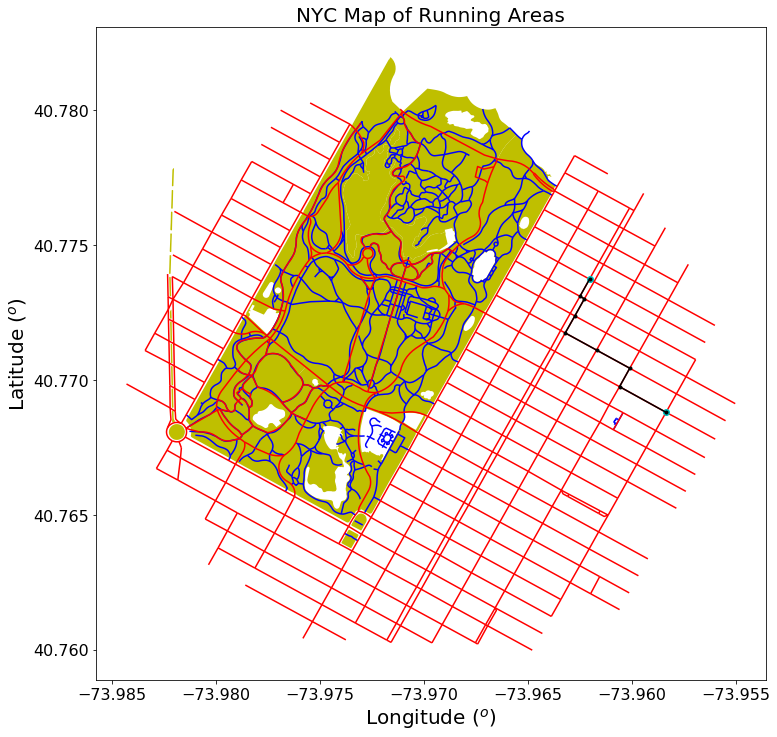

In [323]:
# plotting the selected data
fig, ax2 = pl.subplots(figsize=(12, 12))
borough_df1.plot(ax=ax2, color='y', label='x')  # roads
borough_df2.plot(ax=ax2, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax2, color='r', label='z')  # parks

pl.plot(float(start_point.split('_')[0]), float(start_point.split('_')[1]), 'oc')
pl.plot(float(end_point.split('_')[0]), float(end_point.split('_')[1]), 'oc')

import copy
xx = copy.deepcopy(xxx[1])
prev_pt = None
try:
    while True:
        print('-', xx[0])
        pl.plot(float(xx[0].split('_')[0]), float(xx[0].split('_')[1]), '.k')
        if prev_pt is not None:
            pl.plot([float(xx[0].split('_')[0]), float(prev_pt.split('_')[0])],
                    [float(xx[0].split('_')[1]), float(prev_pt.split('_')[1])], 'k-')
        prev_pt = copy.deepcopy(xx[0])
        xx = copy.deepcopy(xx[1])
except IndexError:
    pass

pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})